In [1]:
import pandas as pd
import xml.etree.ElementTree as ET
import numpy as np
import math as math
import matplotlib.pyplot as plt

## Grid Data

In [2]:
gridData = ET.parse("Grid-Data.xml")

In [3]:
gridDataRoot = gridData.getroot()

In [4]:
class GridPoint:
    def __init__(self, X, y, df):
        self.X = X
        self.Y = Y
        self.df = df
        
    def __str__(self):
        return f"{self.x}, {self.y}"

In [5]:
gridPointsList = []
for grid in gridDataRoot:
    X = grid.find("X").text
    Y = grid.find("Y").text
    data = []
    for wifiPoint in grid.find("wifi"):
        data.append({"mac_ad": wifiPoint.attrib.get("mac_ad"), 
         "rssi": int(wifiPoint.text), 
         "ssid": wifiPoint.attrib.get("ssid")})
    df = pd.DataFrame(data)
    gridPointsList.append(GridPoint(X, Y, df))


## Trial Data (Acceleration, heading etc)

In [6]:
data = ET.parse("data.xml")
TrialDataRoot = data.getroot()

In [7]:
dataPointsList = []
for dataPoint in TrialDataRoot:
    wifi = []
    for wifiPoint in dataPoint.find("wifi"):
        wifi.append({"mac_ad": wifiPoint.attrib.get("mac_ad"), 
         "rssi": wifiPoint.text, 
         "ssid": wifiPoint.attrib.get("ssid")})
        
    dataPointsList.append(
        {
            "Acceleration": float(dataPoint.find("acceleration").text),
            "Heading": float(dataPoint.find("heading").text),
            "Timestamp": int(dataPoint.find("timestamp").text),
            "Wifi": wifi
        }
    )
    
df = pd.DataFrame(dataPointsList)

In [8]:
#Modifying Data
df["Time Elapsed"] = ((df["Timestamp"]-df["Timestamp"][0])/1000000)
df["Acceleration"] = df["Acceleration"]-9.8
df["Heading"] = df["Heading"] - df["Heading"][0]
df

,Acceleration,Heading,Timestamp,Wifi,Time Elapsed
0,0.100184,0.000000,60688732701251,[],0.000000
1,0.098828,0.010279,60688751757221,[],19.055970
2,0.117572,0.016775,60688770813049,[],38.111798
3,0.138135,0.051022,60688789868957,[],57.167706
4,0.104509,0.108327,60688808924737,[],76.223486
...,...,...,...,...,...
881,-0.711288,-162.561719,60705520785783,[],16788.084532
882,-1.215879,-162.070963,60705539841247,[],16807.139996
883,0.177567,-161.800399,60705558896956,[],16826.195705
884,2.075280,-161.654820,60705577952535,[],16845.251284


# Predicting Coordinates

In [9]:
wifi_data = df[df["Wifi"].str.len() != 0]
wifi_data

,Acceleration,Heading,Timestamp,Wifi,Time Elapsed
262,-0.491750,23.126706,60693725324246,"[{'mac_ad': '38:43:7d:a7:f4:2d', 'rssi': '-93'...",4992.622995
472,0.502385,-8.146476,60697727023528,"[{'mac_ad': '38:43:7d:a7:f4:2d', 'rssi': '-93'...",8994.322277
680,-0.954213,-176.458969,60701690600284,"[{'mac_ad': 'ac:22:05:79:93:91', 'rssi': '-92'...",12957.899033


In [10]:
#Number K in KNN
K = 2

#Go Through all the Data Points
for i, dataPoint in wifi_data.iterrows():
    #Collect the cumulative error between every dataPoint and gridPoint
    errors = []
    for gridPoint in gridPointsList:
        #Converting corressponding points to key-value pair data structure with mac_ad as key and rssi and value
        grid_dict = gridPoint.df.set_index("mac_ad").to_dict()["rssi"]
        data_dict = pd.DataFrame(dataPoint["Wifi"]).set_index("mac_ad").to_dict()["rssi"]
        
        #Calculate Cumulative Error
        error = 0
        for key, value in data_dict.items():
            if key in grid_dict:#If keys match, calculate different and add to cumultive error. #Ignore keys that don't match
                error += abs(int(grid_dict[key]) - int(value))
        errors.append({"error": error,
                      "X": gridPoint.X,
                      "Y": gridPoint.Y})

        
    #Sort list by the ascending error
    sorted_list = sorted(errors, key=lambda k: k["error"])
    sorted_list = sorted_list[0:K]
    print(sorted_list)
    
    #Calculate Average distance between the 3 grid points of least error
    x = 0
    y = 0
    for point in sorted_list:
        x += float(point["X"])
        y += float(point["Y"])
    x /= K
    y /= K
    
    #Put Predicted coordinates into original data df
    df.at[i, "Predicted X"] = x
    df.at[i, "Predicted Y"] = y
    print(f"Predicted Coordinates: {x},{y}")


[{'error': 39, 'X': '0.0', 'Y': '2.0'}, {'error': 57, 'X': '0.0', 'Y': '0.0'}]
Predicted Coordinates: 0.0,1.0
[{'error': 39, 'X': '0.0', 'Y': '2.0'}, {'error': 50, 'X': '0.0', 'Y': '0.0'}]
Predicted Coordinates: 0.0,1.0
[{'error': 12, 'X': '0.0', 'Y': '0.0'}, {'error': 19, 'X': '0.0', 'Y': '2.0'}]
Predicted Coordinates: 0.0,1.0


In [11]:
df

,Acceleration,Heading,Timestamp,Wifi,Time Elapsed,Predicted X,Predicted Y
0,0.100184,0.000000,60688732701251,[],0.000000,NaN,NaN
1,0.098828,0.010279,60688751757221,[],19.055970,NaN,NaN
2,0.117572,0.016775,60688770813049,[],38.111798,NaN,NaN
3,0.138135,0.051022,60688789868957,[],57.167706,NaN,NaN
4,0.104509,0.108327,60688808924737,[],76.223486,NaN,NaN
...,...,...,...,...,...,...,...
881,-0.711288,-162.561719,60705520785783,[],16788.084532,NaN,NaN
882,-1.215879,-162.070963,60705539841247,[],16807.139996,NaN,NaN
883,0.177567,-161.800399,60705558896956,[],16826.195705,NaN,NaN
884,2.075280,-161.654820,60705577952535,[],16845.251284,NaN,NaN


# Step Detection

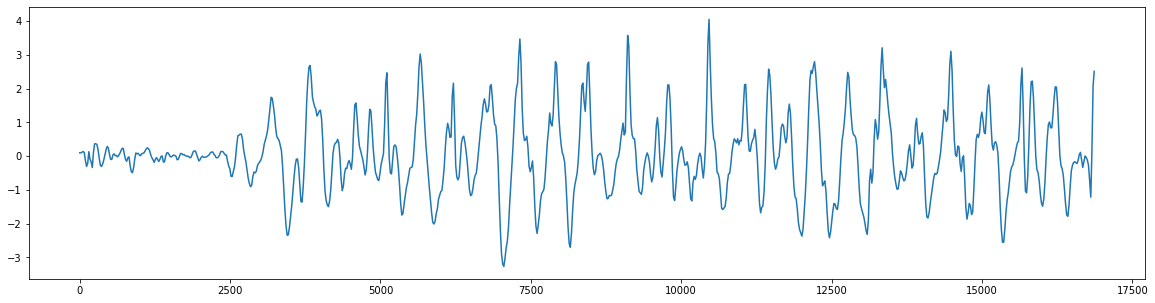

In [12]:
df_accel = df.copy(deep=True)
plt.figure(figsize=(20,5))
plt.plot(df_accel["Time Elapsed"], df_accel["Acceleration"])
plt.show()

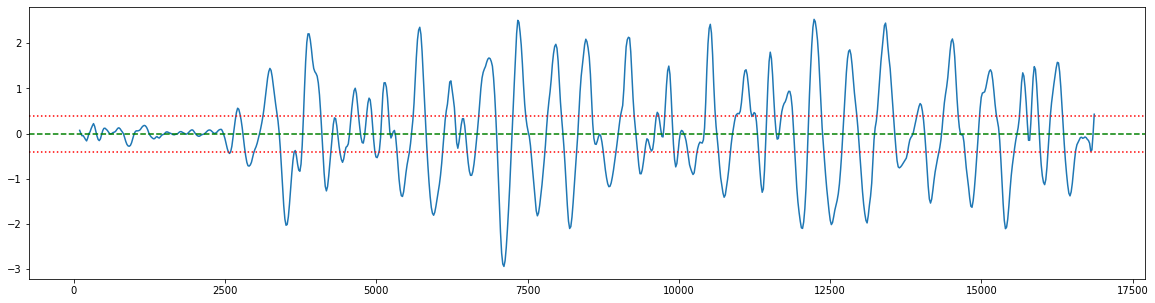

In [13]:
#Do Thresholds
base = 0
margin = 0.4
rolling_mean_window = 6

high_thres = base+margin
low_thres = base-margin

#Smooth the Graph with rolling mean
rolling = df_accel["Acceleration"].rolling(window=rolling_mean_window)
rolling_mean = rolling.mean()
df_accel["Smooth Accel"] = rolling_mean

X = df_accel["Time Elapsed"]
Y = df_accel["Smooth Accel"]

plt.figure(figsize=(20,5))
plt.plot(X, Y)
plt.axhline(y=base, color="green", linestyle='--')
plt.axhline(y=high_thres, color="red", linestyle=':')
plt.axhline(y=low_thres, color="red", linestyle=':')
plt.show()

In [14]:
valleys_indexes = (np.diff(np.sign(np.diff(Y))) > 0).nonzero()[0] + 1      # local min
peaks_indexes = (np.diff(np.sign(np.diff(Y))) < 0).nonzero()[0] + 1       # local max
# +1 due to the fact that diff reduces the original index number

v_x = X[valleys_indexes].reset_index(drop=True)#valleys x values
p_x = X[peaks_indexes].reset_index(drop=True)#peaks x values
v_y = Y[valleys_indexes].reset_index(drop=True)#valleys y values
p_y = Y[peaks_indexes].reset_index(drop=True)#valleys y values

#If the first point is a peak, remove that peak and let valleys go first
if p_x[0] < v_x[0]:
    p_x = p_x.drop(index=p_x.index[0], axis=0).reset_index(drop=True)
    p_y = p_y.drop(index=p_y.index[0], axis=0).reset_index(drop=True)
    
detected_steps = []
for i in range(min(len(v_x),len(p_x))):
    v = [v_x[i], v_y[i]]
    p = [p_x[i], p_y[i]] 
    x1 = v[0]
    x2 = p[0]
    y1 = v[1]
    y2 = p[1]
    if y1 < low_thres and y2 > high_thres:
        m = ((y2-y1)/(x2-x1))
        c = -(m*x1)+y1
        detected_steps.append(-c/m)
        #print(f"{v}, {p}, {(-(m*-x1)+(y1))/m}")
        
len(detected_steps)

22

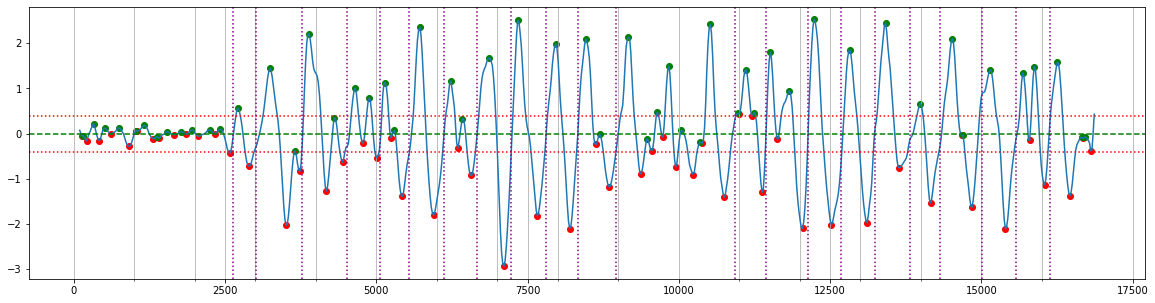

In [15]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1, 1, 1)
minor_tick = []
for i in range(0, int(max(p_x)), 1000):
    minor_tick.append(i)
plt.plot(X, Y)
ax.set_xticks(minor_tick, minor=True)
plt.grid(axis="x", which="both")
plt.scatter(x=v_x, y=v_y, color="red")
plt.scatter(x=p_x, y=p_y, color="green")
plt.axhline(y=base, color="green", linestyle='--')
plt.axhline(y=high_thres, color="red", linestyle=':')
plt.axhline(y=low_thres, color="red", linestyle=':')
for i in detected_steps:
    plt.axvline(x=i, color="purple", linestyle=":")
plt.show()

# Particle Filter

In [16]:
import pandas as pd
import numpy as np
from numpy import random
from numpy.random import uniform
import math
import time
import plotly.express as px
import plotly.graph_objects as go

In [24]:
#Return array of random particles with 3 columns. X, Y , Heading
def create_uniform_particles(x_min, x_max, y_min, y_max, N):
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(x_min, x_max, size=N)
    particles[:, 1] = uniform(y_min, y_max, size=N)
    particles[:, 2] = uniform(0, 360, size=N)
    return particles
        
#Apply movement to each particle
dist_std=0.3#Step Distance std
angle_std=3
def apply_movement(particles, distance, angle):
    moved_particles = np.empty((len(particles), 3))
    for i in range(len(particles)):
        #Adding noise
        noisy_distance = random.normal(distance, dist_std)
        noisy_angle = random.normal(angle, angle_std)
        
        #New heading direction for particle
        direction = particles[i][2] + noisy_angle
        x = particles[i][0] + (noisy_distance * math.cos((direction * math.pi) / 180))
        y = particles[i][1] + (noisy_distance * math.sin((direction * math.pi) / 180))

        moved_particles[i] = [x,y,direction]
    return moved_particles

def validate_angle(angle):
    if angle >= 360:
        return angle-360
    elif angle < 0:
        return angle+360
    else:
        return angle
    
    
    
    

def calculate_weights(particles, predicted_location):
    weights = []
    sum = 0
    #Get Sum of distances from all particles
    for particle in particles:
        d = distance(particle, predicted_location)
        p = predict(d)
        weights.append(p)
        sum += p
    weights[:] = [x / sum for x in weights]

    #return likelihood for all particles between 0 and 1 all summing to 1
    return weights

def distance(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

diameter = 1.1 # Diameter will be increased/Greater distances won't be punished as severely
concentration = 10 # Weights will be more concentrated towards the center/Exponentiality will be increased
def predict(distance):
    return np.exp(-(distance/diameter)**concentration)
    
    
    
resample_std=3
def resample(particles, weights, N):
    new_particles=np.empty((N,3))
    
    for i in range(N):
        index = random.choice(np.arange(0,len(weights), 1), p=weights)
        x = random.normal(particles[index][0], resample_std)
        y = random.normal(particles[index][1], resample_std)
        direction = random.normal(particles[index][2], angle_std)
        
        new_particles[i] = [x,y,direction]
    #Return particles that tend towards the weights
    return new_particles



def reset():
    #Number of particles
    N=300
    #Map constraints
    x_range = np.array([-20, 20])
    y_range = np.array([-20, 20])
    #Create random particles in random locations
    particles = create_uniform_particles(x_range[0], x_range[1], y_range[0], y_range[1], N)
    #All weights for particles
    weights = np.array([1/N]*N)
    
    return N, x_range, y_range, particles, weights

In [25]:
N, x_range, y_range, particles, weights = reset()

#Main of the Particle Filter

#Function to show real Location for each plot
x=0#Starting Coordinates
y=0
dist=0
angle=90
def update_data(x, y, dist, angle):
    x = x + (dist * math.cos((angle * math.pi) / 180))
    y = y + (dist * math.sin((angle * math.pi) / 180))
    return x, y, dist, angle

#Plot intial particles
fig = px.scatter(x=particles[:,0], y=particles[:,1])#size=weights changes size of points
fig.update_layout(width = 700, height = 500, xaxis_range=[-70,70], yaxis_range=[-70,70], title = "Samples from prior")
#Plot Real Location
fig.add_trace(go.Scatter(x=[x, x],y=[y, y],mode = 'markers'))
fig.show()
    

    
#The main iterative process for particle filter
counter = 0
for i, row in df.iterrows():
    #If predicted coords are available then apply it
    if (not math.isnan(row["Predicted X"])):

        weights = calculate_weights(particles, [row["Predicted X"], row["Predicted Y"]])
        particles = resample(particles, weights, 300)
    
    #If not steps left then ignore
    if len(detected_steps) == counter:
        continue
    #If Step detected at this time point, then apply movement
    if row["Time Elapsed"] >= detected_steps[counter]:
        particles = apply_movement(particles, 0.85, row["Heading"])
        counter += 1
        #Plot particles
        fig = px.scatter(x=particles[:,0], y=particles[:,1])#size=weights changes size of points
        fig.update_layout(width = 700, height = 500, xaxis_range=[-70,70], yaxis_range=[-70,70], title = "Samples from prior")
        #Plot Real Location
        x, y, dist, angle = update_data(x, y, 0.85, row["Heading"])
        fig.add_trace(go.Scatter(x=[x, x],y=[y, y],mode = 'markers'))
        fig.show()

#time.sleep(3)

    
angle_std=10

In [19]:
math.isnan(df["Predicted X"][262]) 

False